In [1]:
%matplotlib inline
'''
How to Train Your Dragon: V5
Sequentially optimize an already initialized FT reactive distillation process

Capability includes:

Temperature, Reflux, Product Flow Rate, Feed Allocation, Catalyst Allocation and Tray Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-07 18:08:41 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=10,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
#     return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
#             sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
    return pe.log(model.scale_epi + (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total))\
            == pe.log(model.scale_epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma))
            
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True, scale = True)

In [16]:
opt.options['required_infeasibility_reduction'] = 0.999999999999999

In [17]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

In [18]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6481  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.8  0.000       0.000  0.000  0.000  0.000       5.7751  0.0000  0.7526  0.0000       20.000
NON--[2]     132.0  0.000       0.000  0.000  0.000  0.000       5.8796  0.0000  0.6828  0.0000       20.000
NON--[3]     141.4  0.000       0.000  0.000  0.000  0.000       5.8098  0.0000  0.6177  0.0023       20.000
NON--[4]     150.0  0.000       0.000  0.000  0.000  

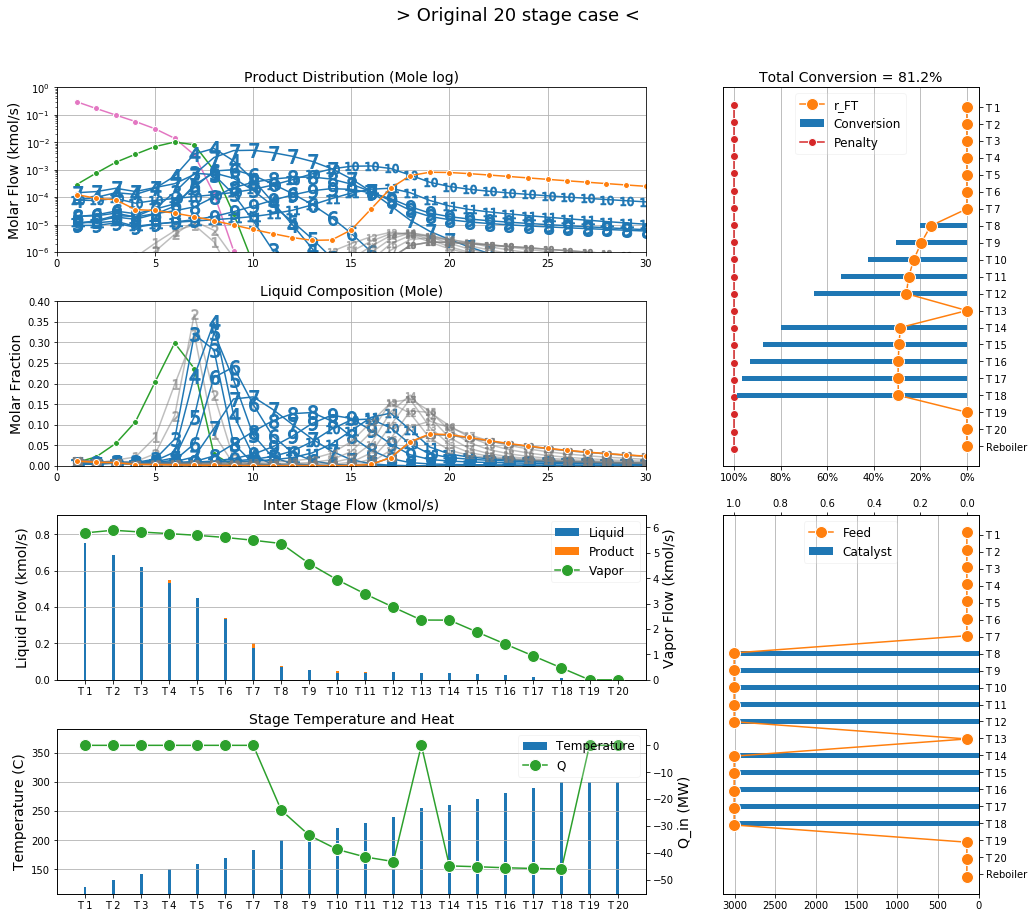

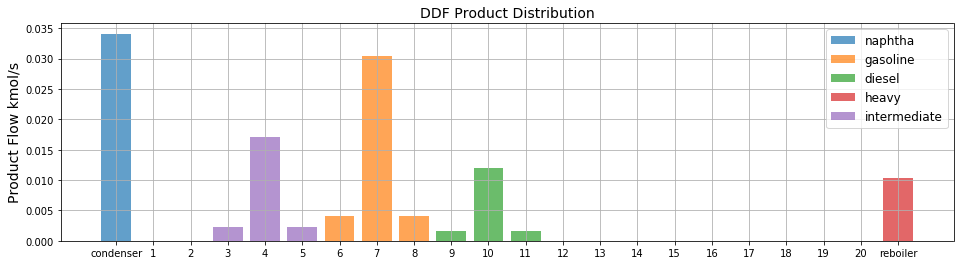

In [19]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [20]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [21]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [22]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [23]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.0227009e-01 1.73e-01 1.40e+01  -6.0 6.86e+02    -  1.00e+00 1.36e-01h  2
  66 -1.0227067e-01 6.28e-02 1.74e-02  -6.0 7.39e+01    -  1.00e+00 1.00e+00h  1
  67 -1.0227096e-01 1.44e-04 5.20e-05  -6.0 3.60e+00    -  1.00e+00 1.00e+00h  1
  68 -1.0227096e-01 2.84e-10 1.95e-11  -6.0 1.42e-03    -  1.00e+00 1.00e+00h  1
  69 -1.0240519e-01 1.28e+00 5.24e+01  -9.0 2.07e+02    -  8.66e-01 9.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0238866e-01 7.73e-01 3.27e+01  -9.0 3.75e+01    -  8.97e-01 3.60e-01h  1
  71 -1.0235869e-01 2.50e-02 4.00e-01  -9.0 2.35e+01    -  1.00e+00 9.85e-01h  1
  72 -1.0235758e-01 1.05e-04 1.74e-04  -9.0 9.56e-01    -  1.00e+00 1.00e+00h  1
  73 -1.0235758e-01 3.05e-10 9.07e-11  -9.0 2.47e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:  -1.0235758259792335e-01   -1.0235758259792335e-01
Dual infeas


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 88.03%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1386          0.9921  0.0871       2.3285

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.7  0.000       0.000  0.000  0.000  0.000       5.5466  0.0000  1.2312  0.0000       20.000
NON--[2]     149.7  0.000       0.000  0.000  0.000  0.000       5.7857  0.0000  1.1758  0.0000       20.000
NON--[3]     160.9  0.000       0.000  0.000  0.000  0.000       5.7303  0.0000  1.1268  0.0000       20.000
NON--[4]     170.0  0.00

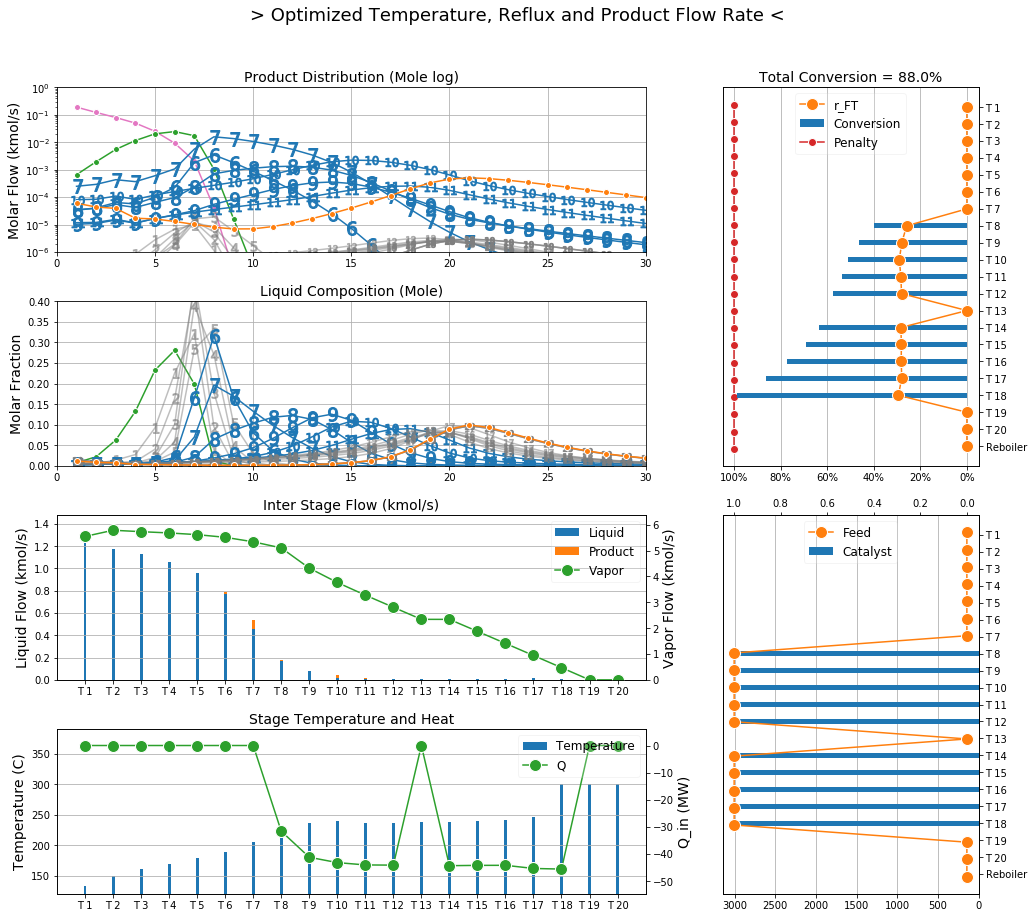

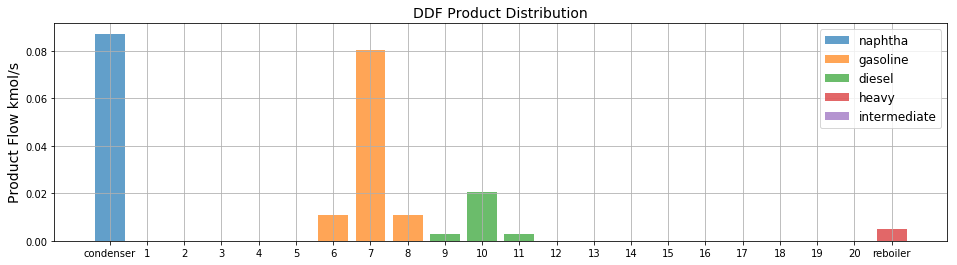

In [24]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [25]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2080680e-01 2.11e+01 3.80e+01  -6.0 1.38e+03    -  4.03e-02 1.00e+00H  1
  66 -1.2078735e-01 2.09e+01 3.76e+01  -6.0 7.45e+03 -10.6 2.95e-01 1.30e-02h  1
  67 -1.2077063e-01 1.76e+01 3.13e+01  -6.0 6.12e+02    -  1.00e+00 1.65e-01h  1
  68 -1.2069439e-01 1.24e+00 2.38e+00  -6.0 3.07e+02    -  1.00e+00 1.00e+00h  1
  69 -1.2068717e-01 1.03e-02 1.27e+00  -6.0 2.78e+01    -  2.26e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2072313e-01 4.26e-01 5.51e-01  -6.0 1.70e+02    -  1.00e+00 1.00e+00h  1
  71 -1.2073047e-01 2.31e-01 1.02e-01  -6.0 3.67e+01  -9.3 8.02e-01 1.00e+00h  1
  72 -1.2076832e-01 1.39e+00 6.17e-01  -6.0 1.84e+02    -  1.00e+00 1.00e+00h  1
  73 -1.2080655e-01 5.49e-01 6.39e-01  -6.0 1.91e+02    -  1.00e+00 1.00e+00h  1
  74 -1.2083948e-01 4.31e-01 4.84e-01  -6.0 1.69e+02    -  1.00e+00 1.00e+00h  1
  75 -1.2083970e-01 1.48e-04 5.11e-04  -6.0 2.70e+00    -  1.00e+00 1.00e+00h  1
  76 -1.2083971e-01 6.06e-09

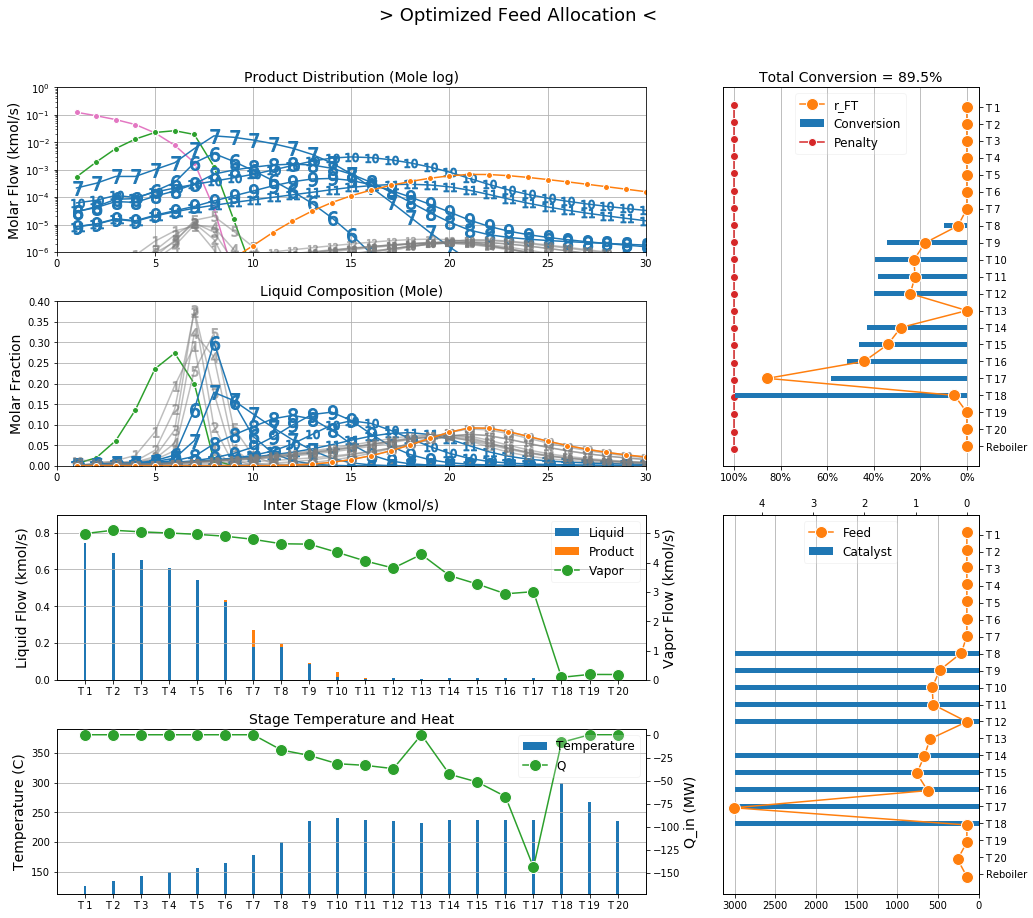

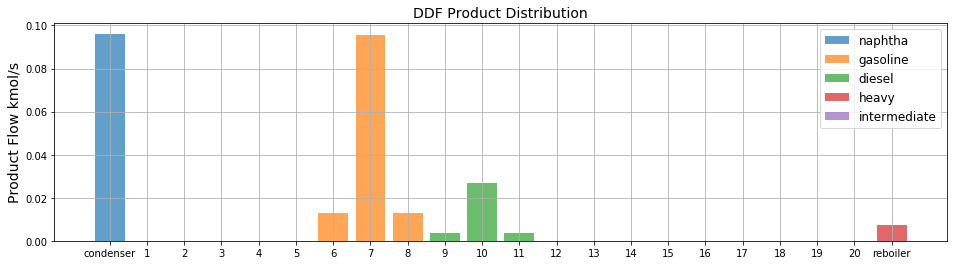

In [26]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)
    
# soft constraints to guide the feed allocation pattern
model.reactive[17].F.setlb(3)

results = opt.solve(model,tee=True)
update_dual(pe,model)

with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Allocation')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Feed Allocation')
plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [27]:
# for j in model.TRAY_reactive:
#     model.reactive[j].cat.unfix()
#     model.reactive[j].cat.setlb(10)
#     model.reactive[j].cat.setub(30000)

In [28]:
# model.total_cat_con = pe.ConstraintList()
# model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [29]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [30]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     check_product_spec(model)
#     log_now()
#     check_iteration()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
# plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [31]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [32]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.42%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -146.                                        1.8377          0.5664  0.0906       2.4167

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.7  0.000       0.000  0.000  0.000  0.000       4.9115  0.0000  0.6553  0.0000       20.000
NON--[2]     131.4  0.000       0.000  0.000  0.000  0.000       5.0004  0.0000  0.5970  0.0000       20.000
NON--[3]     139.2  0.000       0.000  0.000  0.000  0.000       4.9421  0.0000  0.5476  0.0000       20.000
NON--[4]     147.1  0.000       0.000  0.000  0.

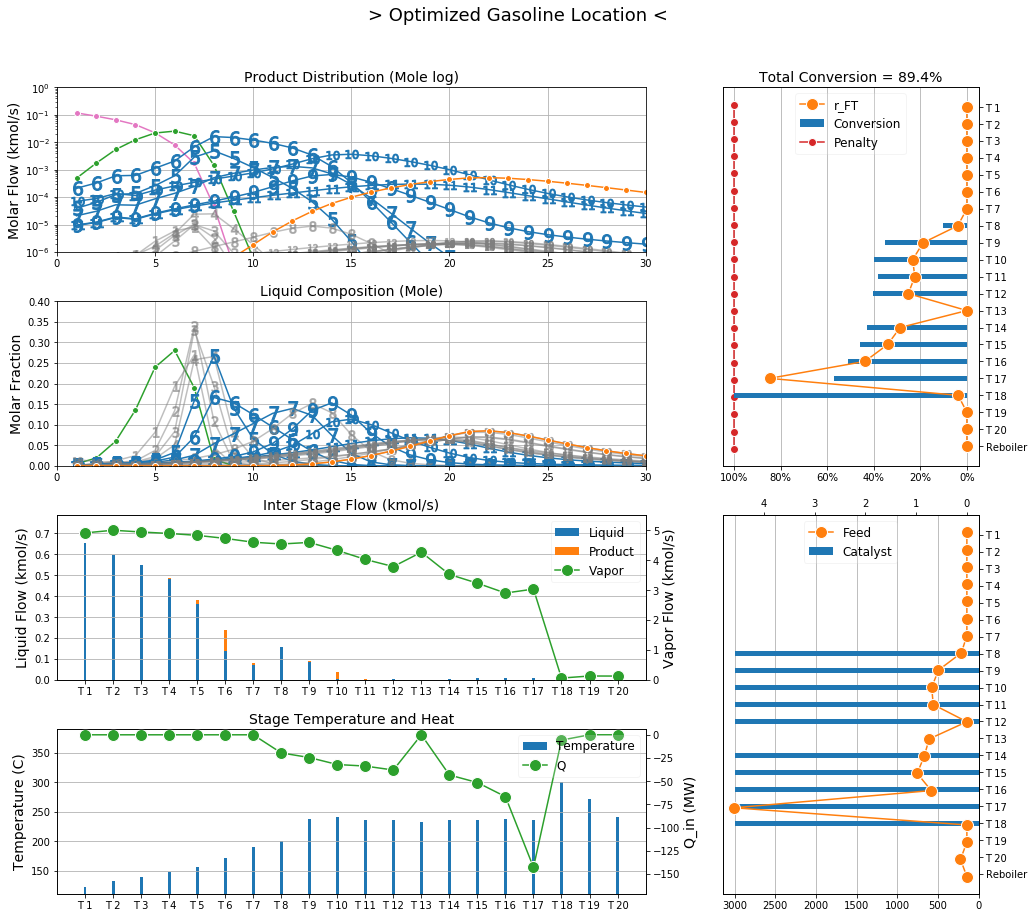

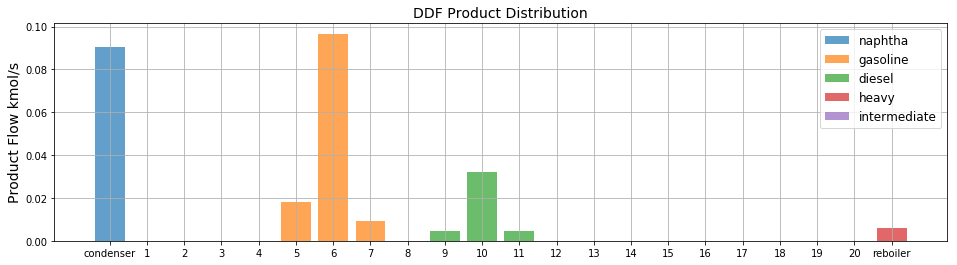

In [33]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Gasoline Location')
plot_product_distribution(model,pdf)

In [34]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(5)
model.N_tray['diesel'].setub(19)

In [35]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2654004e-01 3.24e-02 2.03e+03  -6.0 1.36e+01  -7.3 2.89e-01 1.00e+00h  1
  66 -1.2659796e-01 3.06e-02 1.60e+03  -6.0 5.06e+01  -7.8 2.50e-01 1.94e-01h  1
  67 -1.2662247e-01 5.87e-02 1.12e+03  -6.0 9.22e+01  -8.3 2.74e-01 2.17e-01f  1
  68 -1.2672847e-01 1.38e-01 5.37e+00  -6.0 8.62e+01  -8.8 1.00e+00 1.00e+00f  1
  69 -1.2681505e-01 2.55e-01 6.83e+00  -6.0 1.20e+02  -9.2 9.49e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2681829e-01 4.97e-01 9.43e-01  -6.0 1.01e+02  -9.7 1.00e+00 1.00e+00h  1
  71 -1.2681144e-01 2.51e-01 1.62e-01  -6.0 4.13e+01  -9.3 1.00e+00 1.00e+00h  1
  72 -1.2680622e-01 3.60e-01 2.59e+00  -6.0 2.08e+02  -9.8 1.00e+00 3.16e-01h  2
  73 -1.2679898e-01 3.99e-01 1.22e+01  -6.0 9.15e+02 -10.2 8.39e-01 9.10e-02h  2
  74 -1.2678950e-01 4.01e-01 1.58e+01  -6.0 1.29e+03    -  8.98e-01 7.23e-02h  2
  75 -1.2677912e-01 3.21e-01 5.93e+00  -6.0 4.42e+02    -  8.18e-01 2.42e-01h  2
  76 -1.2677627e-01 8.97e-02

 158 -1.2979746e-01 5.72e+01 6.14e+00  -9.0 2.90e+03 -10.8 1.00e+00 6.23e-01h  1
 159 -1.2980331e-01 3.03e+01 4.17e+02  -9.0 1.93e+02    -  1.00e+00 4.70e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.2986877e-01 4.27e+01 1.49e+02  -9.0 3.38e+03    -  6.16e-02 3.24e-01h  1
 161 -1.2991757e-01 3.49e+01 1.18e+03  -9.0 1.64e+03    -  2.88e-02 2.91e-01h  1
 162 -1.3010085e-01 3.86e+01 2.94e+07  -9.0 1.37e+03    -  3.42e-05 1.00e+00f  1
 163 -1.3025956e-01 4.01e+01 2.59e+07  -9.0 4.46e+03  -9.5 1.98e-01 1.19e-01h  1
 164 -1.3047069e-01 9.24e-02 1.81e+04  -9.0 6.38e+01    -  1.51e-01 1.00e+00h  1
 165 -1.3054346e-01 2.31e-01 1.50e+00  -9.0 1.02e+02  -8.1 1.00e+00 1.00e+00h  1
 166 -1.3066210e-01 7.07e-01 2.06e+01  -9.0 6.28e+02  -8.6 4.14e-01 2.46e-01h  1
 167 -1.3084206e-01 8.05e-01 3.33e+01  -9.0 2.17e+02  -8.2 1.00e+00 7.82e-01h  1
 168 -1.3086222e-01 6.53e-01 3.24e+03  -9.0 4.22e+01    -  5.63e-02 1.90e-01h  1
 169 -1.3098308e-01 4.81e-01


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.64%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -148.                                        1.8068          0.6126  0.0879       2.4332

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.7  0.000       0.000  0.000  0.000  0.000       4.9407  0.0000  0.7130  0.0000       20.000
NON--[2]     131.3  0.000       0.000  0.000  0.000  0.000       5.0411  0.0000  0.6530  0.0000       20.000
NON--[3]     139.1  0.000       0.000  0.000  0.000  0.000       4.9812  0.0000  0.6023  0.0000       20.000
NON--[4]     147.1  0.000       0.000  0.000  0.00

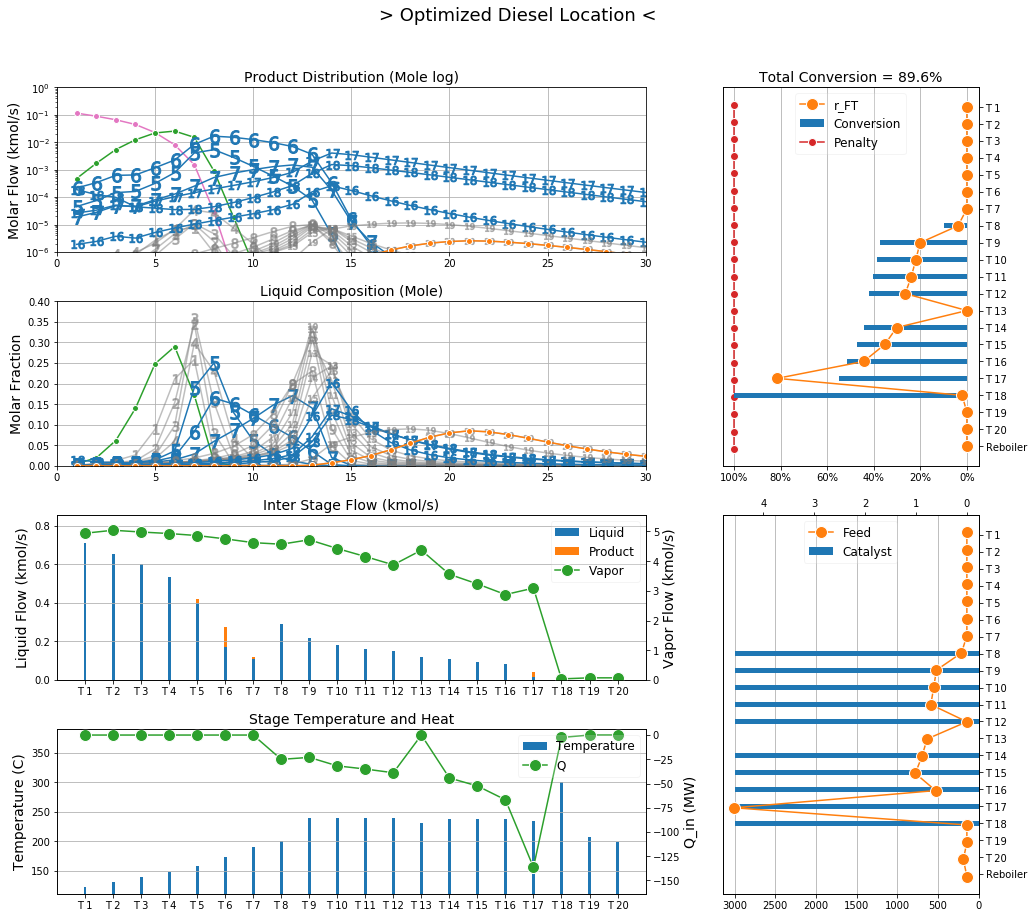

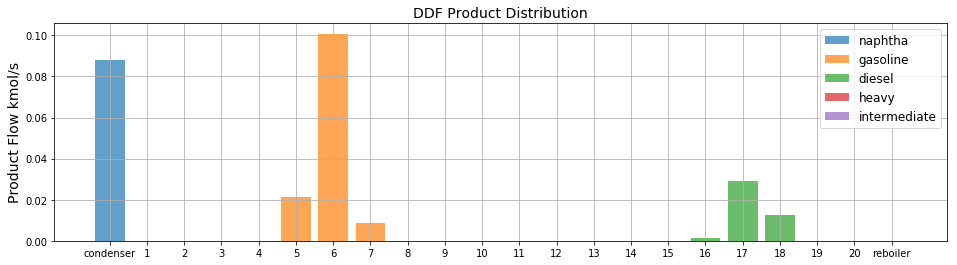

In [36]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

In [37]:
pdf.close()

In [38]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)